# TP3 : Ondelettes

Enseignants: 

    S. Zhang (2022), J. Chirinos-Rodriguez (2025) (jonathaneduardo.chirinosrodriguez@toulouse-inp.fr)

Ce TP doit être réalisé en une séance de 2h.

Il faut installer la librairie Kymatio version 0.2.1: `$ pip install kymatio==0.2.1`.

**Acknowledgements: L. Mousset (2023), P. Richard (2024)**

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.fftpack import fft2, ifft2  # FFT à 2 dimension
import torch

import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score

from kymatio.scattering2d.filter_bank import filter_bank

from kymatio.scattering2d.backend.torch_backend import fft
from kymatio.backend.torch_backend import cdgmm

from utils import load_obj, colorize, convert_cls2fls  # Librairie maison

# Chargement des données

Dans ce TP, nous allons utiliser les mêmes données qu'aux TP 1 et 2. Normalement, elles ont été sauvées sous un format pickle (.pkl) dans le dossier contenant ce Notebook. Pour les charger, il suffit de faire :

In [4]:
### Paramètres
NbClasses = 9  # Nombre de classes
SizeMaps = 256  # Taille des cartes 256x256 pixels
NbMapsTrain = 20 # Nombre de cartes par classe dans le jeu d'apprentissage
NbMapsTest = 15  # Nombre de cartes par classe dans le jeu de test

### Chargement des données
ImgsTrain = load_obj('ImgsTrain')
ImgsTest = load_obj('ImgsTest')

Dans ce TP, nous allons avoir besoin de la fonction `classify_by_LDA()` codée au TP 1. Vous pouvez la recopier dans la cellule suivante. 

In [5]:
def classify_by_LDA(dataTrain: dict, dataTest: dict) -> dict:
    """
    This function performs classification using Linear Discriminant Analysis (LDA).
    It converts the input data into features and labels, fits an LDA classifier,
    and evaluates the classifier's performance on both training and test data.
    The performance metrics include confusion matrices and accuracy scores.
    """
    # Build features and labels
    featuresTrain, labelsTrain = convert_cls2fls(dataTrain, NbClasses, NbMapsTrain)
    featuresTest, labelsTest = convert_cls2fls(dataTest, NbClasses, NbMapsTest)

    # Initialize and fit the LDA classifier
    clf = LinearDiscriminantAnalysis()
    clf.fit(featuresTrain, labelsTrain)

    # Predict and evaluate
    predsTrain = clf.predict(featuresTrain)
    predsTest = clf.predict(featuresTest)

    cmatTrain = confusion_matrix(labelsTrain, predsTrain)
    cmatTest = confusion_matrix(labelsTest, predsTest)

    accuracyTrain = accuracy_score(labelsTrain, predsTrain)
    accuracyTest = accuracy_score(labelsTest, predsTest)

    return {
        'train_cm': cmatTrain,
        'train_acc': accuracyTrain,
        'test_cm': cmatTest,
        'test_acc': accuracyTest,
        'lda': clf
    }

# 1. Construction d'un jeu d'ondelettes multi-échelles

**1.1 TODO :** En utilisant la fonction `filter_bank()` de la librairie `kymatio`, construire un jeu d'ondelettes de Morlet 2D avec 5 échelles et 4 angles.

Cette fonction retourne une liste de deux dictionnaires: la Scaling function $\phi$ (filtre passe bas) et le jeu d'ondelettes $\psi$. Les ondelettes sont définies dans l'espace de Fourier.

In [8]:
from kymatio.scattering2d.filter_bank import filter_bank

J = 5  # Nombre d'échelles
L = 4  # Nombre d'angles

# Construire un jeu d'ondelettes
filters_set = filters_set = filter_bank(SizeMaps, SizeMaps, J, L=L)

**1.2 TODO :** Tracer les ondelettes dans l'espace réel ($J \times L$ plots).

On peut utiliser la fonction home made `colorize` pour les couleurs. 


In [52]:
filters_set['psi']

[{'j': 0,
  'theta': 0,
  0: array([[-2.98023224e-08,  4.46686149e-03,  9.04999673e-03, ...,
          -1.26810372e-02, -8.57603550e-03, -4.34836745e-03],
         [ 4.46688384e-03,  9.04932618e-03,  1.37493387e-02, ...,
          -8.55237246e-03, -4.33607399e-03,  4.32878733e-06],
         [ 9.05002654e-03,  1.37493610e-02,  1.85675174e-02, ...,
          -4.31147218e-03,  1.74567103e-05,  4.47198749e-03],
         ...,
         [-1.26810223e-02, -8.55238736e-03, -4.31147218e-03, ...,
          -2.43728533e-02, -2.05931440e-02, -1.66952685e-02],
         [-8.57599825e-03, -4.33607399e-03,  1.74567103e-05, ...,
          -2.05931216e-02, -1.67064741e-02, -1.27001330e-02],
         [-4.34835255e-03,  4.35858965e-06,  4.47197258e-03, ...,
          -1.66952610e-02, -1.27001405e-02, -8.58387351e-03]], dtype=float32)},
 {'j': 0,
  'theta': 1,
  0: array([[-4.4732701e-08, -4.4719158e-08, -4.4678533e-08, ...,
          -4.4610861e-08, -4.4678533e-08, -4.4719158e-08],
         [ 5.9493193e-03

/tmp/ipykernel_44380/432038175.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


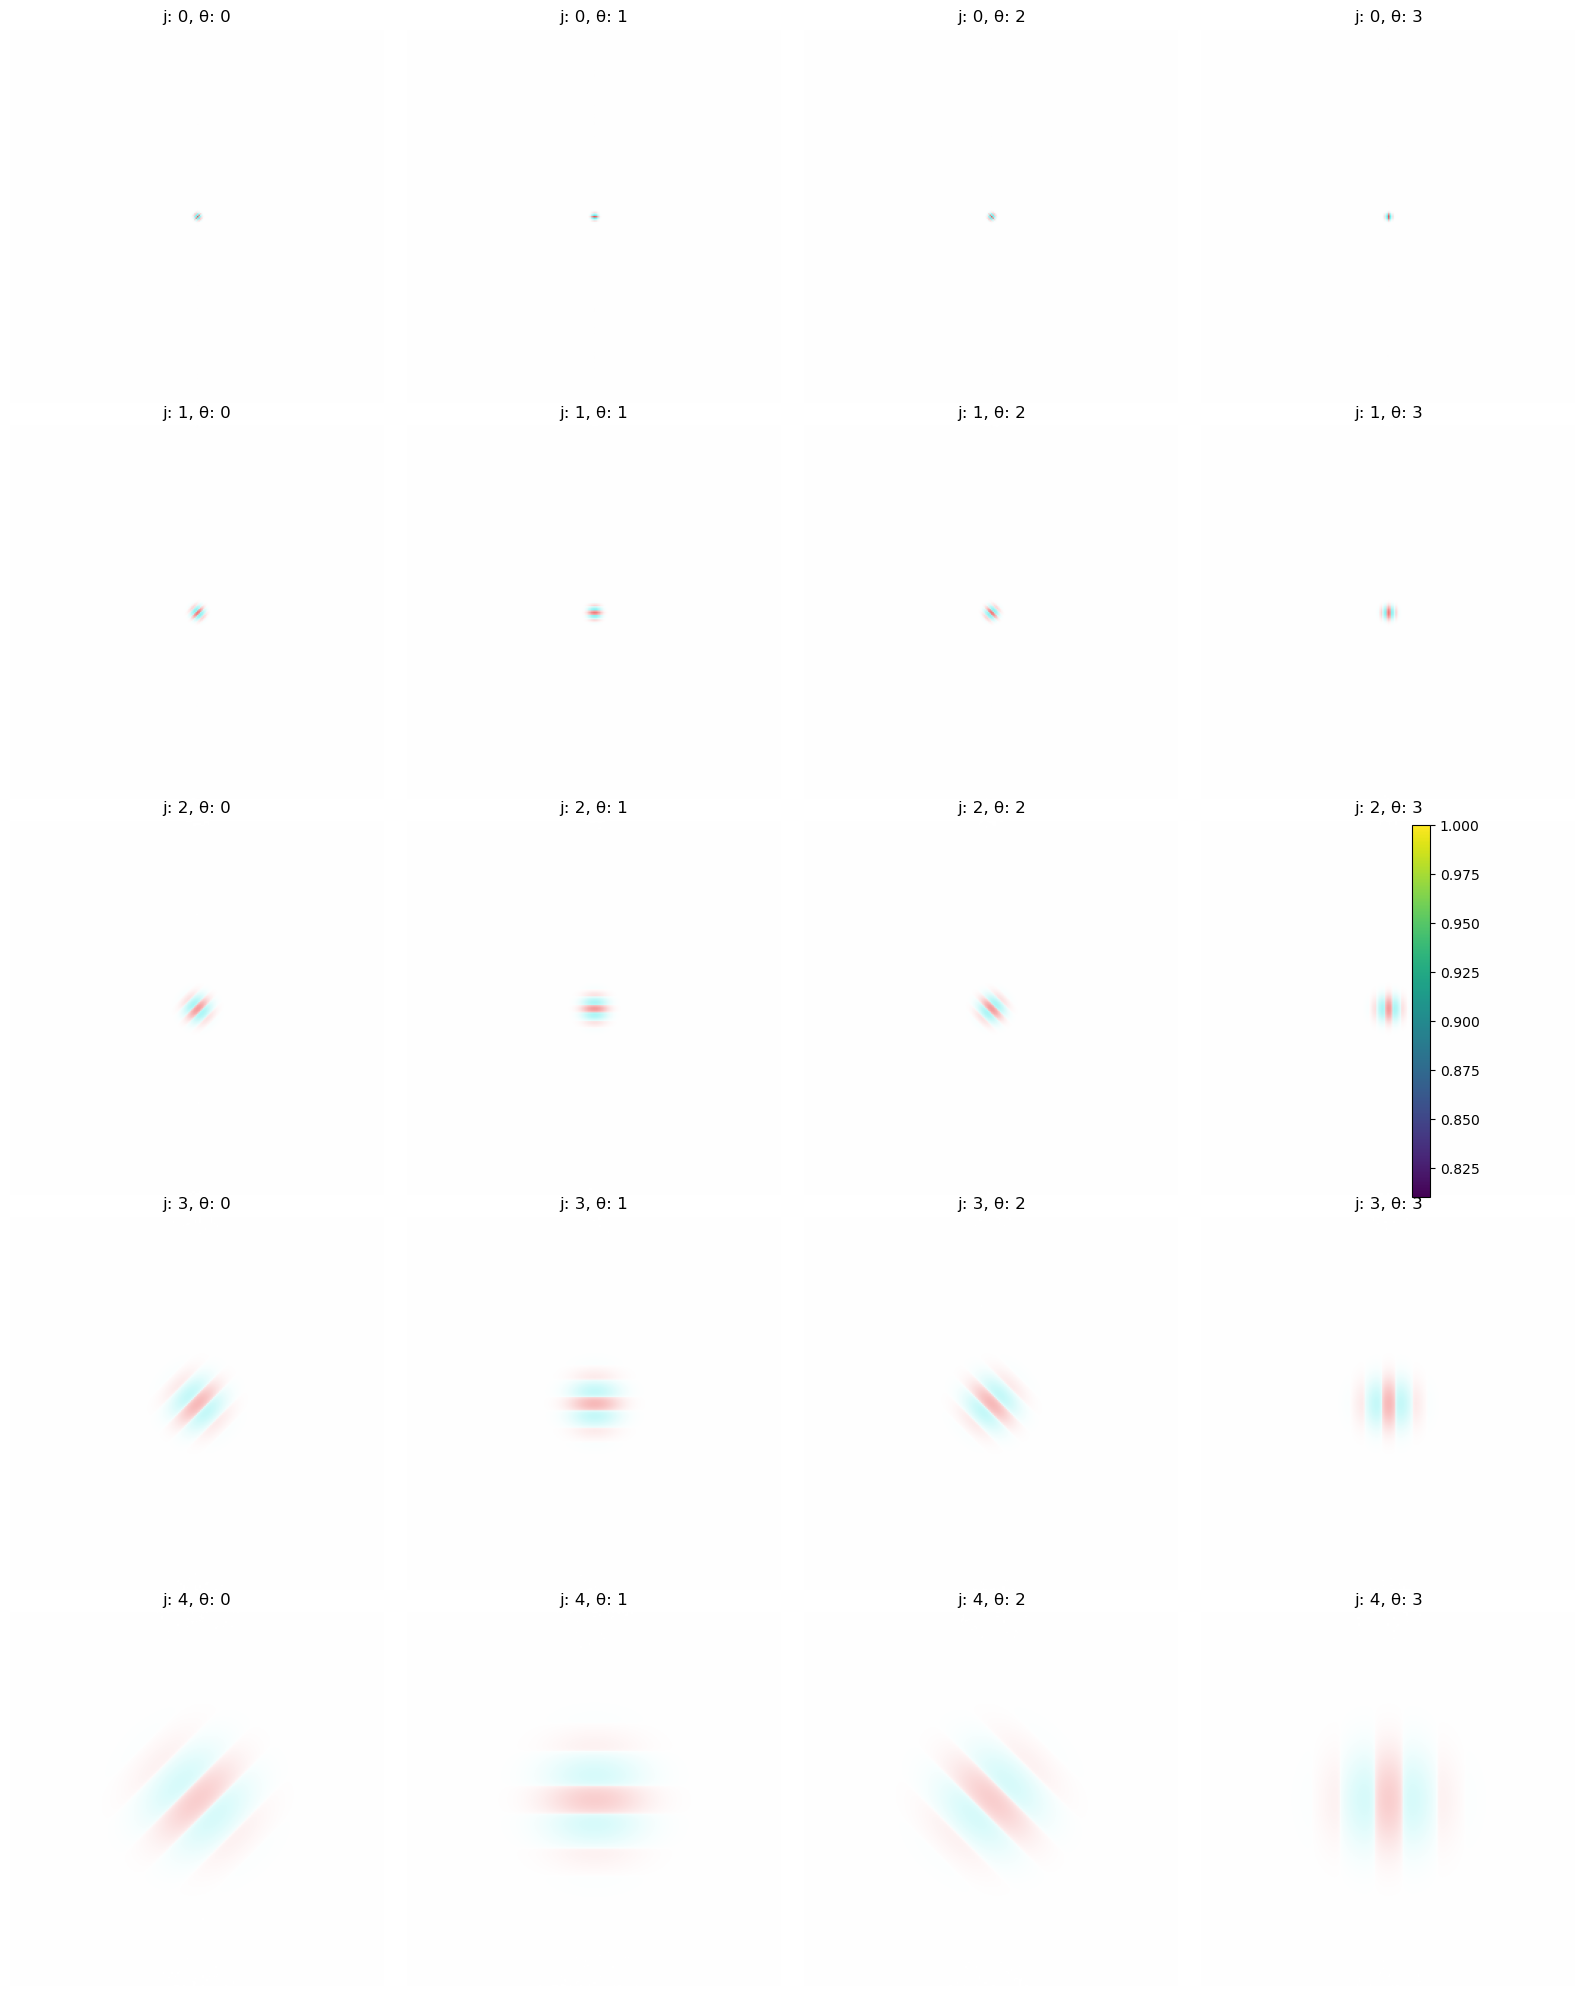

In [83]:
import matplotlib.pyplot as plt

filters = filters_set['psi']

num_filters = len(filters)

fig, axs = plt.subplots(5, 4, figsize=(16, 20))

axs = axs.ravel()

for idx, wavelet_dict in enumerate(filters):
    if idx < len(axs):  
        wavelet = wavelet_dict[0]
        wavelet = np.real(np.fft.fftshift(ifft2(wavelet)))
        im = axs[idx].imshow(colorize(wavelet), cmap='viridis')
        axs[idx].axis('off')
        axs[idx].set_title(f'j: {wavelet_dict["j"]}, θ: {wavelet_dict["theta"]}')

for idx in range(num_filters, len(axs)):
    axs[idx].axis('off')

fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.015, pad=0.05)

plt.tight_layout()
plt.show()

**1.3 TODO :** Tracer également le filtre passe bas dans l'espace réel.

/tmp/ipykernel_44380/13419667.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


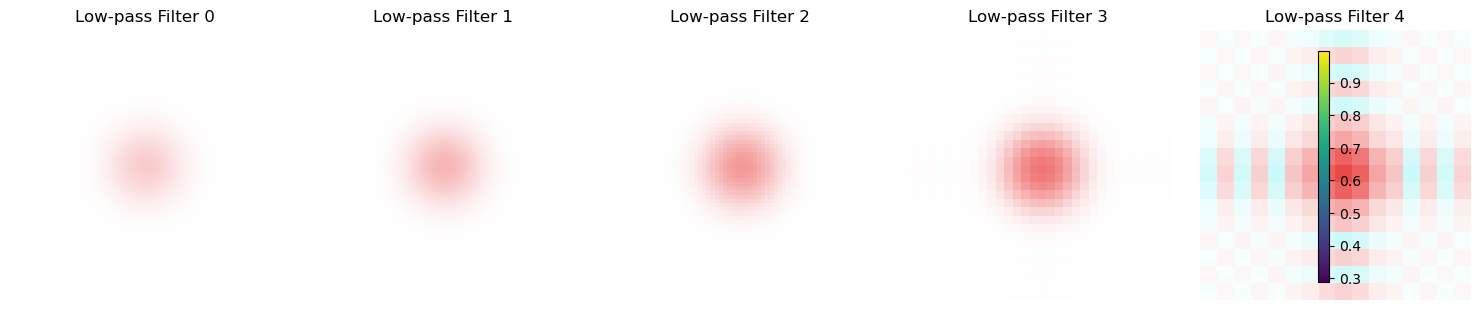

In [84]:
import matplotlib.pyplot as plt

phi_filters = filters_set['phi']

num_filters = len(phi_filters) - 1  

fig, axs = plt.subplots(1, num_filters, figsize=(num_filters * 3, 3))

for idx in range(num_filters):
    filter_array = phi_filters[idx]
    filter_array =  np.real(np.fft.fftshift(ifft2(filter_array)))
    im = axs[idx].imshow(colorize(filter_array), cmap='viridis')
    axs[idx].axis('off')
    axs[idx].set_title(f'Low-pass Filter {idx}')

fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.015, pad=0.05)

plt.tight_layout()
plt.show()

Pour la suite, on convertit les filtres en tenseurs PyTorch.

In [85]:
#### Ondelettes stockées dans une liste
filters = []
for fil in filters_set['psi']:
    f = fil[0]  # On récupère le tableau de valeurs
    hatpsi = torch.zeros(SizeMaps, SizeMaps, 2)  # Initialisation du Tenseur Torch [256, 256, 2]
    hatpsi[:, :, 0] = torch.from_numpy(f)  # On remplit le tenseur
    filters.append(hatpsi)  # On ajoute le Tenseur à la liste

#### Filtre passe-bas
f = filters_set['phi'][0]  # On récupère le tableau de valeurs
hatphi = torch.zeros(SizeMaps,SizeMaps,2)  # Initialisation du Tenseur Torch
hatphi[:, :, 0] = torch.from_numpy(f)  # On remplit le tenseur
filters.append(hatphi)  # On ajoute le Tenseur à la liste, ce sera le dernier élément

# 2. Tranformée en ondelettes des images

On va calculer la transformée en ondelettes (Wavelet Transform) des images. C'est la convolution des images $I$ par le jeu d'ondelettes $\Psi_{j\theta}$:
$$ W_{j\theta} = I * \Psi_{j\theta} $$

**2.1 TODO :** Comment s'écrit cette convolution dans l'espace de Fourier ?

**2.2 TODO :** Compléter la fonction suivante qui réalise la transformée en ondelettes des images. Le calcul sera fait dans l'espace de Fourier. On fera les calculs en `Pytorch`. Attention à la gestion des nombres complexes, il faut séparer partie réelle et partie imaginaire (dernière dimension de taille 2). Cela n'est plus forcément vrai avec la version récente de `PyTorch`.  Appliquer cette fonction sur les données d'apprentissage et de validation.

In [88]:
def compute_wavelet_coeffs(Imgs, filters, NbClasses, NbMaps, SizeMaps):
    wavcoeffs_cls = {}  # Initialisation du dictionnaire
    NbFilters = len(filters)  # Nombre de filtres (ondelette et passe-bas)
    
    for i in range(1,NbClasses+1):  # Boucle sur les classes
        # %%%%% TODO %%%%%
        wavcoeffs = torch.zeros((NbMaps, len(filters), SizeMaps, SizeMaps, 2))
        for j in range(NbMaps) :
            for k, f in enumerate(filters):
                img = Imgs[i][j]
                img_c = torch.zeros(SizeMaps,SizeMaps,2)
                img_c[:,:,0] = torch.from_numpy(img)
                img_fft = fft(img_c,'C2C', inverse = False)
                wavcoeffs[j,k] = cdgmm(img_fft,f)
        # %%%%% end TODO %%%%% 
                
        wavcoeffs_cls[i] = fft(wavcoeffs,'C2C', inverse = True)   # Place les coeffs de la classe i dans le dictionnaire
    return wavcoeffs_cls 

In [89]:
# %%%%% TODO %%%%%
wavcoeffsTrain = compute_wavelet_coeffs(ImgsTrain, filters, NbClasses, NbMapsTrain, SizeMaps)
wavcoeffsTest = compute_wavelet_coeffs(ImgsTest, filters, NbClasses, NbMapsTest, SizeMaps)
# %%%%% end TODO %%%%%

**2.3 TODO :** Afficher la partie réelle et la partie imaginaire de la transformée en ondelette pour une image et quelques filtres que vous choisirez.

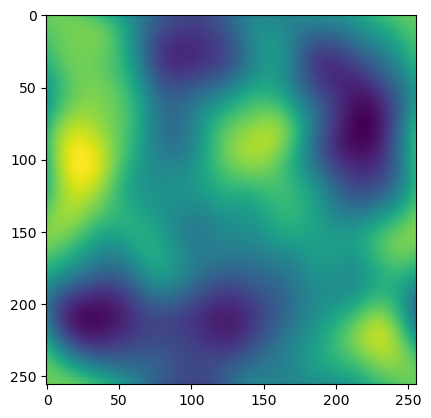

In [106]:
# %%%%% TODO %%%%%
### Plot
plt.imshow(wavcoeffsTrain[1][5][20,:,:,1]) # imaginaire
plt.imshow(wavcoeffsTrain[1][5][20,:,:,0]) # réelle
plt.show()

# 3. Calcul de la norme L2

**3.1 TODO :** Compléter la fonction suivante qui calcule la norme L2 de la transformée en ondelettes. Puis l'appliquer aux coefficients obtenus à l'étape 2.

In [102]:
def compute_features_l2(wavcoeffs_cls, filters, NbClasses, NbMaps, SizeMaps):
    wavl2_cls = {}
    NbFilters = len(filters)  
    
    for i in range(1,NbClasses+1):  
        wavl2 = torch.zeros((NbMaps, NbFilters))
        for j in range(NbMaps) :
            for k in range(NbFilters) :
                wavl2[j, k] = torch.norm(wavcoeffs_cls[i][j, k, :, :,:], p=2)
        wavl2_cls[i] = wavl2        
    return wavl2_cls

In [103]:
wavl2Train = compute_features_l2(wavcoeffsTrain, filters, NbClasses, NbMapsTrain, SizeMaps)
wavl2Test = compute_features_l2(wavcoeffsTest, filters, NbClasses, NbMapsTest, SizeMaps)

**3.2 TODO :** Pour une image donnée, tracer la norme L2 associée à chaque filtre. On utilisera l'échelle log pour l'axe des ordonnées. Décrire le plot. A quoi correspondent les marches d'escalier ? Quelle propriété traduit la faible variations des coefficients au sein d'une même marche ? Pourquoi le dernier point est-il isolé ?

In [ ]:
i = 0  # Indice de la classe
j = 1  # Indice de l'image

# %%%%% TODO %%%%%
### Plot

# %%%%% end TODO %%%%%

**3.3 TODO :** Tracer la norme L2 associée à chaque classe, on moyennera sur les images (on représentera aussi la dispersion intra-classe). On pourra séparer l'affichage par groupe de filtres ayant la même échelle.

In [ ]:
# %%%%% TODO %%%%%
### Plot

# %%%%% end TODO %%%%%

# 4. Calcul de la norme L1

**4.1 TODO :** Reprendre exactement les 3 questions de la partie 3 mais pour la norme L1.

In [ ]:
def compute_features_l1(wavcoeffs_cls, filters, NbClasses,NbMaps,SizeMaps):
    wavl1_cls = {}
    NbFilters = len(filters)  # Nombre de filtres
    
    for i in range(NbClasses):  # Boucle sur les classes
        # %%%%% TODO %%%%%

        # %%%%% end TODO %%%%%
        
    return wavl1_cls

# %%%%% TODO %%%%%
wavl1Train = 
wavl1Test =
# %%%%% end TODO %%%%%

In [ ]:
i = 0  # Indice de la classe
j = 1  # Indice de l'image

# %%%%% TODO %%%%%
### Plot

# %%%%% end TODO %%%%%


In [ ]:
# %%%%% TODO %%%%%
### Plot

# %%%%% end TODO %%%%%

# 5. Analyse LDA avec les normes L1 et L2 

**5.1 TODO :** Comme aux TP 1 et 2, réaliser une analyse LDA avec la norme L2 puis la norme L1. Afficher les matrices de confusions et les test d'accuracy sur les données d'apprentissage et sur les données de validation.


In [ ]:
### Avec la norme L2

# %%%%% TODO %%%%%
resultsl2 =

# %%%%% end TODO %%%%%

In [ ]:
### Avec la norme L1

# %%%%% TODO %%%%%
resultsl1 = 

# %%%%% end TODO %%%%%

**5.2 TODO :** On fixe le nombre d'angle à L=4. Comment les précisions sur les données d'apprentissage et de test varient-elles en fonction de du nombre d'échelles J ?


In [ ]:
# %%%%% TODO %%%%%

# %%%%% end TODO %%%%%

**5.3 TODO :** On fixe le nombre d'échelles J et d'angles L. Refaire une analyse LDA en utilisant à la fois la norme L1 et la norme L2.

In [ ]:
# %%%%% TODO %%%%%

# %%%%% end TODO %%%%%